In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import numpy as np
import matplotlib.pyplot as plt

# from tqdm.notebook import tqdm
from tqdm import tqdm
from functions import (
    get_var_hist,
    get_p_x4_small_delay,
)
from setup import (
    setup_matplotlib,
    one_col,
    std_height,
    two_col,
    sim_plt_set,
    num_plt_set,
    eigenv_plt_set,
    short_plt_set
)
from functions import SimulationManager, SolverManager, EigenvectorManager
from timeit import default_timer as timer

setup_matplotlib()

np.random.seed(42)

In [12]:
version = 2

s = 1
D = s**2 / 2
max_t = 6  # 2
ntau = 2  # 3 2
N_x = 61  # 61 # 21
hist_sigma = 4
force = "cubic"
avg_part = 4

N_p = 2_000
N_loop = 20
ntau_sim = 30

ltaus = np.concatenate(([0, 0.01,0.02,0.03,0.04 ,0.05], np.arange(0.1, 1.01, 0.1)))

sim_vars = np.empty((len(ltaus), 4))
num_vars = np.empty((len(ltaus), 4))
sim_hist_vars = np.empty((len(ltaus), 4))
eig_vars = np.empty((len(ltaus), 2))
short_time_approx_var = np.empty(len(ltaus))
escaped_traj = np.empty(len(ltaus))
sbs = np.empty(len(ltaus))

In [13]:
my_sim_manager = SimulationManager()

for i, ltau in enumerate(tqdm(ltaus)):
    ldt = ltau / ntau_sim if ltau > 0 else ltaus[1] / ntau_sim
    N_t = int(max_t / ldt) + 1
    # filter = [-np.sqrt(7/4/ltau), np.sqrt(7/4/ltau)] if ltau > 0 else None
    filter = [-hist_sigma, hist_sigma]

    res = my_sim_manager.run(
        N_p=N_p,
        N_loop=N_loop,
        N_t=N_t,
        N_x=N_x,
        ntau=ntau_sim if ltau > 0 else 0,
        s=s,
        dt=ldt,
        x_0=0,
        force=force,
        hist_sigma=hist_sigma,
        norm_sigma=True,
        filter = filter,
    )

    sim_ts = np.arange(0, (N_t + ntau_sim)) * ldt - ltau
    sim_var = res["sim_var"]
    sim_hist_var = res["sim_hist_var"]
    hist_sum = res["hist_sum"]
    x_s = res["x_s"]
    sbs[i] = -x_s[0]

    high_res_x_s = np.linspace(x_s[0], x_s[-1], 1000)
    short_time_p = get_p_x4_small_delay(high_res_x_s, ltau)
    short_time_approx_var[i] = get_var_hist(short_time_p, high_res_x_s)

    escaped_traj[i] = 1 - np.sum(hist_sum[:, -1]) / (N_p * N_loop)

    mean_sim_vars = np.mean(sim_var[:, -N_t // avg_part :], axis=1)
    sim_vars[i] = (
        np.mean(mean_sim_vars),
        np.std(mean_sim_vars) / np.sqrt(N_loop),
        np.min(np.mean(sim_var[:, -N_t // avg_part :], axis=0)),
        np.max(np.mean(sim_var[:, -N_t // avg_part :], axis=0)),
    )

    mean_sim_hist_var = np.mean(sim_hist_var[:, -N_t // avg_part :], axis=1)
    sim_hist_vars[i] = (
        np.mean(mean_sim_hist_var),
        np.std(mean_sim_hist_var) / np.sqrt(N_loop),
        np.min(np.mean(sim_hist_var[:, -N_t // avg_part :], axis=0)),
        np.max(np.mean(sim_hist_var[:, -N_t // avg_part :], axis=0)),
    )

100%|██████████| 16/16 [00:00<00:00, 333.35it/s]


In [14]:
my_num_manager = SolverManager()

for i, ltau in enumerate(tqdm(ltaus)):
    ldt = ltau / ntau if ltau > 0 else ltaus[1] / ntau
    N_t = int(max_t / ldt) + 1
    ts = np.arange(0, N_t) * ldt
    sb = sbs[i]

    res = my_num_manager.run(
        N_t=N_t,
        N_x=N_x,
        sb=sb,
        ntau=ntau if ltau > 0 else 0,
        s=s,
        dt=ldt,
        x_0=0,
        force=force,
    )

    num_var = res["num_var"]
    mean_num_var = np.mean(num_var[-N_t // avg_part :])
    num_vars[i] = (
        mean_num_var,
        0,
        np.min(num_var[-N_t // avg_part :]),
        np.max(num_var[-N_t // avg_part :]),
    )

100%|██████████| 16/16 [00:00<00:00, 829.72it/s]


In [15]:
eigen_manager = EigenvectorManager()

for i, ltau in enumerate(tqdm(ltaus[ltaus < np.pi / 2])):
    ldt = ltau / ntau if ltau > 0 else ltaus[1] / ntau
    sb = sbs[i]

    res = eigen_manager.run(
        N_x=N_x,
        sb=sb,
        ntau=ntau if ltau > 0 else 0,
        s=s,
        dt=ldt,
        force=force,
    )
    eig_vars[i] = (res["eig_var"], 0)

100%|██████████| 16/16 [00:00<00:00, 1482.74it/s]


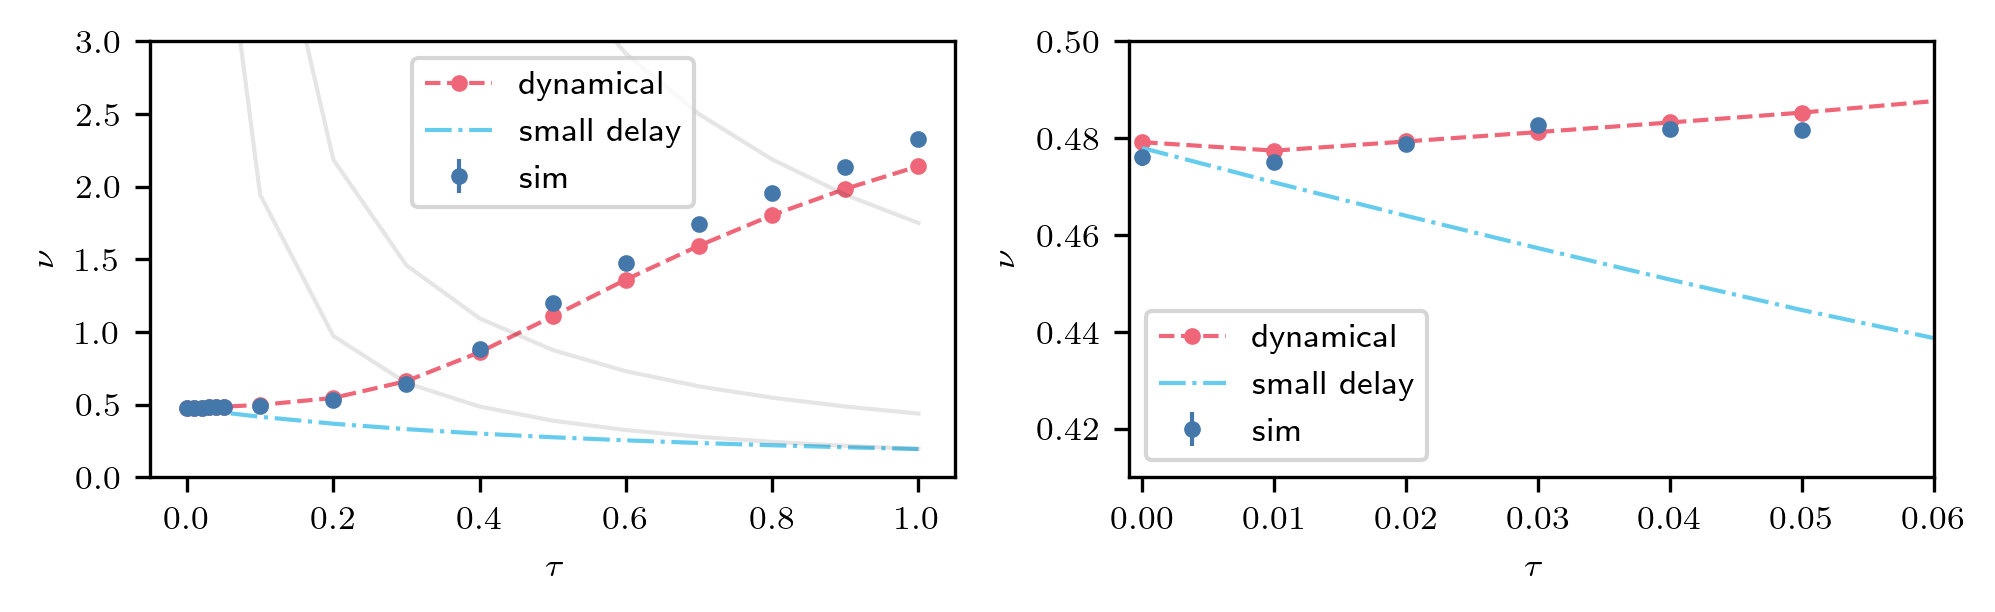

In [16]:
plt.figure(figsize=(two_col, std_height))
ax = plt.subplot(121)
plt.errorbar(ltaus, *sim_vars.T[:2], **sim_plt_set)
# plt.errorbar(ltaus, *sim_hist_vars.T[:2], marker=".", ls="-", label="hist-sim")
plt.plot(ltaus, num_vars[:, 0], **num_plt_set)
# plt.plot(ltaus, eig_vars[:,0], **eigenv_plt_set)

plt.plot(ltaus, short_time_approx_var, **short_plt_set)


# plt.yscale('log')
plt.legend()
plt.xlabel(r"$\tau$")
plt.ylabel(r"$\nu$")
plt.ylim(*plt.ylim())

# plt.plot(ltaus, (2/3)**2*ltaus**(-1), color = 'black')
plt.plot(ltaus[1:],         (np.sqrt(7) / 2) ** 2 * ltaus[1:] ** (-1), alpha = 0.1, color="black")
plt.plot(ltaus[1:], 1 / 4 * (np.sqrt(7) / 2) ** 2 * ltaus[1:] ** (-1), alpha = 0.1, color="black")
plt.plot(ltaus[1:], 1 / 9 * (np.sqrt(7) / 2) ** 2 * ltaus[1:] ** (-1), alpha = 0.1 ,color="black")

# plt.xlim(0,0.2)
plt.ylim(0,3)

plt.subplot(122)
plt.errorbar(ltaus, *sim_vars.T[:2], **sim_plt_set)
# plt.errorbar(ltaus,*sim_hist_vars.T[:2],marker='.', ls = '-', label='hist-sim')
plt.plot(ltaus, num_vars[:, 0], **num_plt_set)
# plt.plot(ltaus, eig_vars[:,0], **eigenv_plt_set)

plt.plot(ltaus, short_time_approx_var, **short_plt_set)

plt.xlim(-0.001, 0.06)
plt.ylim(0.41, 0.5)
plt.legend()
plt.xlabel(r"$\tau$")
plt.ylabel(r"$\nu$")

plt.tight_layout()
plt.savefig(f'graphics/x4variance_Nx{N_x}_Nt{ntau}.pdf')

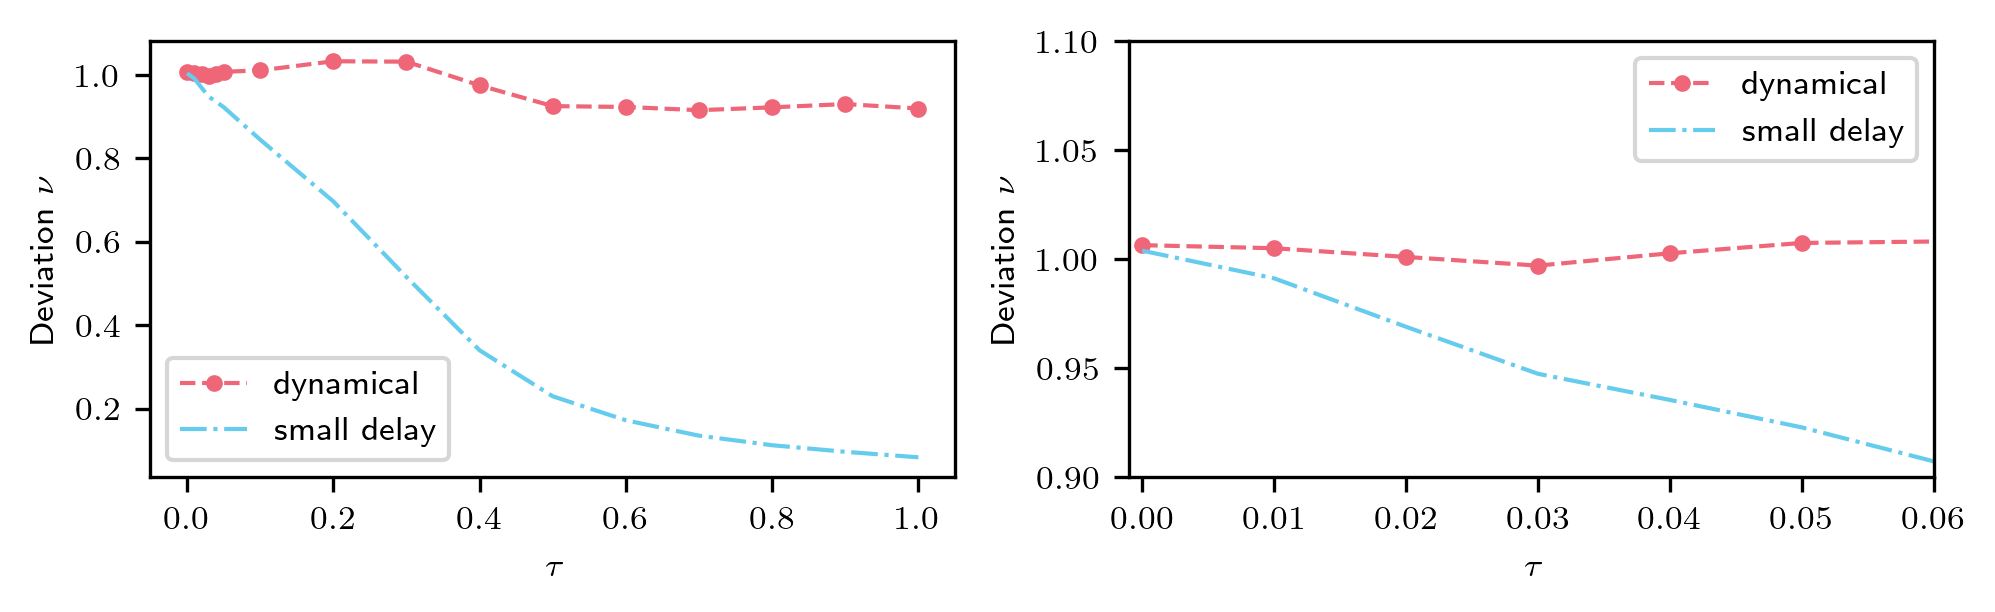

In [17]:
plt.figure(figsize=(two_col, std_height))
ax = plt.subplot(121)
plt.plot(ltaus, num_vars[:, 0]/sim_vars[:,0], **num_plt_set)
plt.plot(ltaus, short_time_approx_var/sim_vars[:,0], **short_plt_set)


# plt.yscale('log')
plt.legend()
plt.xlabel(r"$\tau$")
plt.ylabel(r"Deviation $\nu$")
# plt.ylim(0.9,1.1)
# plt.hlines([1.04,0.92], *plt.xlim())
# auflösungslimit std same as div x0


# plt.xlim(0,0.2)

plt.subplot(122)
plt.plot(ltaus, num_vars[:, 0]/sim_vars[:,0], **num_plt_set)
plt.plot(ltaus, short_time_approx_var/sim_vars[:,0], **short_plt_set)

plt.xlim(-0.001, 0.06)
plt.ylim(0.9, 1.1)

plt.legend()
plt.xlabel(r"$\tau$")
plt.ylabel(r"Deviation $\nu$")

plt.tight_layout()
plt.savefig(f'graphics/additional/x4variance_Nx{N_x}_Nt{ntau}_deviation.pdf')

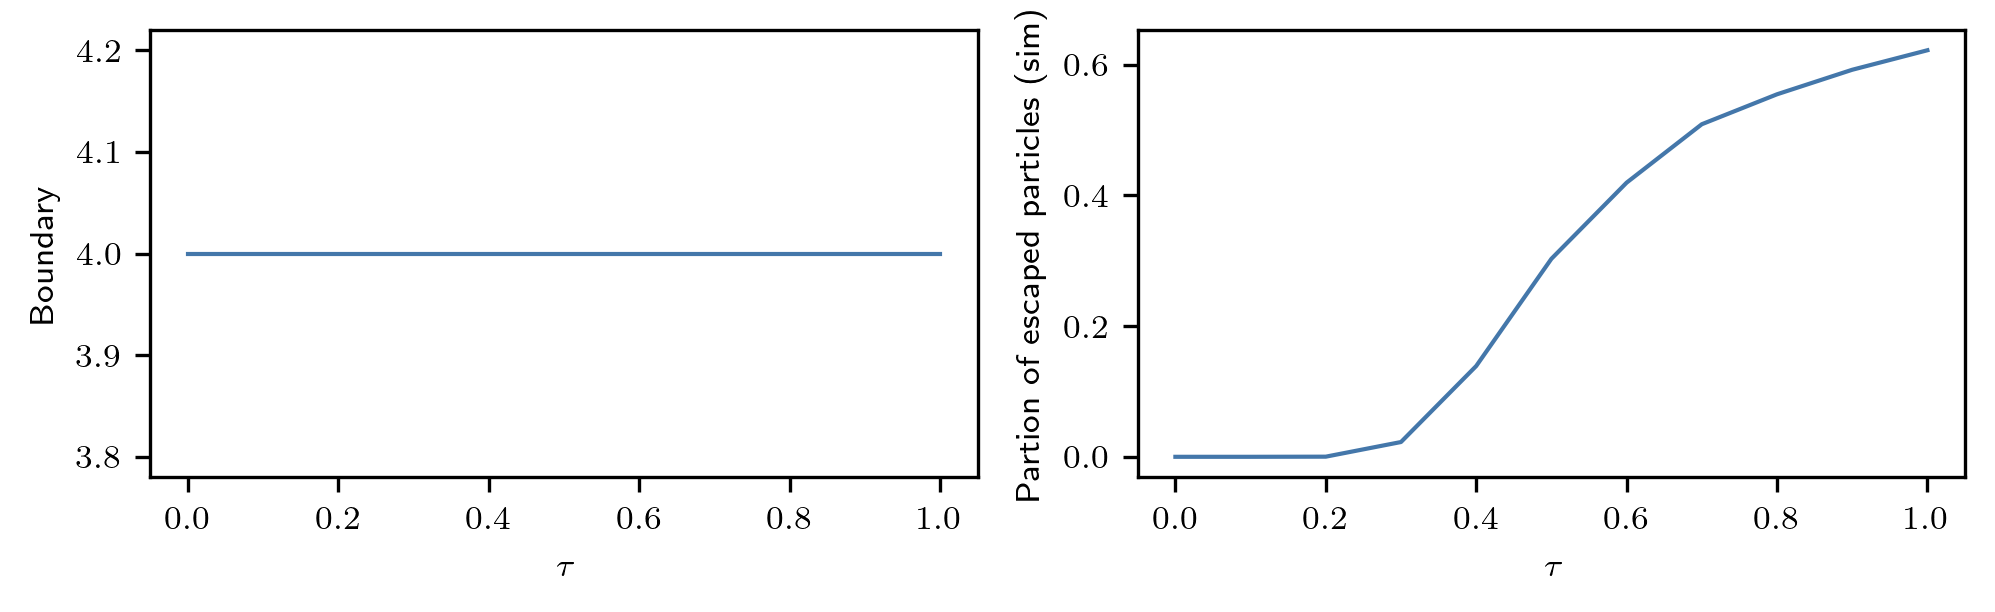

In [18]:
fig, axs = plt.subplots(1,2,figsize=(two_col, std_height))
axs[0].plot(ltaus, sbs)
axs[0].set_xlabel(r'$\tau$')
axs[0].set_ylabel('Boundary')
axs[1].plot(ltaus, escaped_traj)
axs[1].set_xlabel(r'$\tau$')
axs[1].set_ylabel('Partion of escaped particles (sim)')
plt.tight_layout()